# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [7]:
files = os.listdir(folder)
files = files[11:12]

In [8]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [9]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.0086):
    SquelchSignal = []

    for i in range(StallRange):
        SquelchSignal.append(1)

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+2*StallRange]) < SquelchLevel:
            SquelchSignal.append(0)
        else:
            SquelchSignal.append(1)

    for i in range(StallRange+1):
        SquelchSignal.append(1)    
    
    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    if len(Timestamps) == 1:
        dTime = Timestamps
    elif len(Timestamps) == len(Acceleration):
        totTime = 0
        for i in range(len(Timestamps)-1):
            if Timestamps[i]<Timestamps[i+1]:
                totTime += (Timestamps[i+1] - Timestamps[i])
            else:
                totTime += (Timestamps[i+1] - Timestamps[i] + 10000)
        dTime = totTime / len(Timestamps)
    else:
        print('error')

    dTime = dTime / 10000.0

    velocity[0] = Acceleration[0] * (dTime)

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity



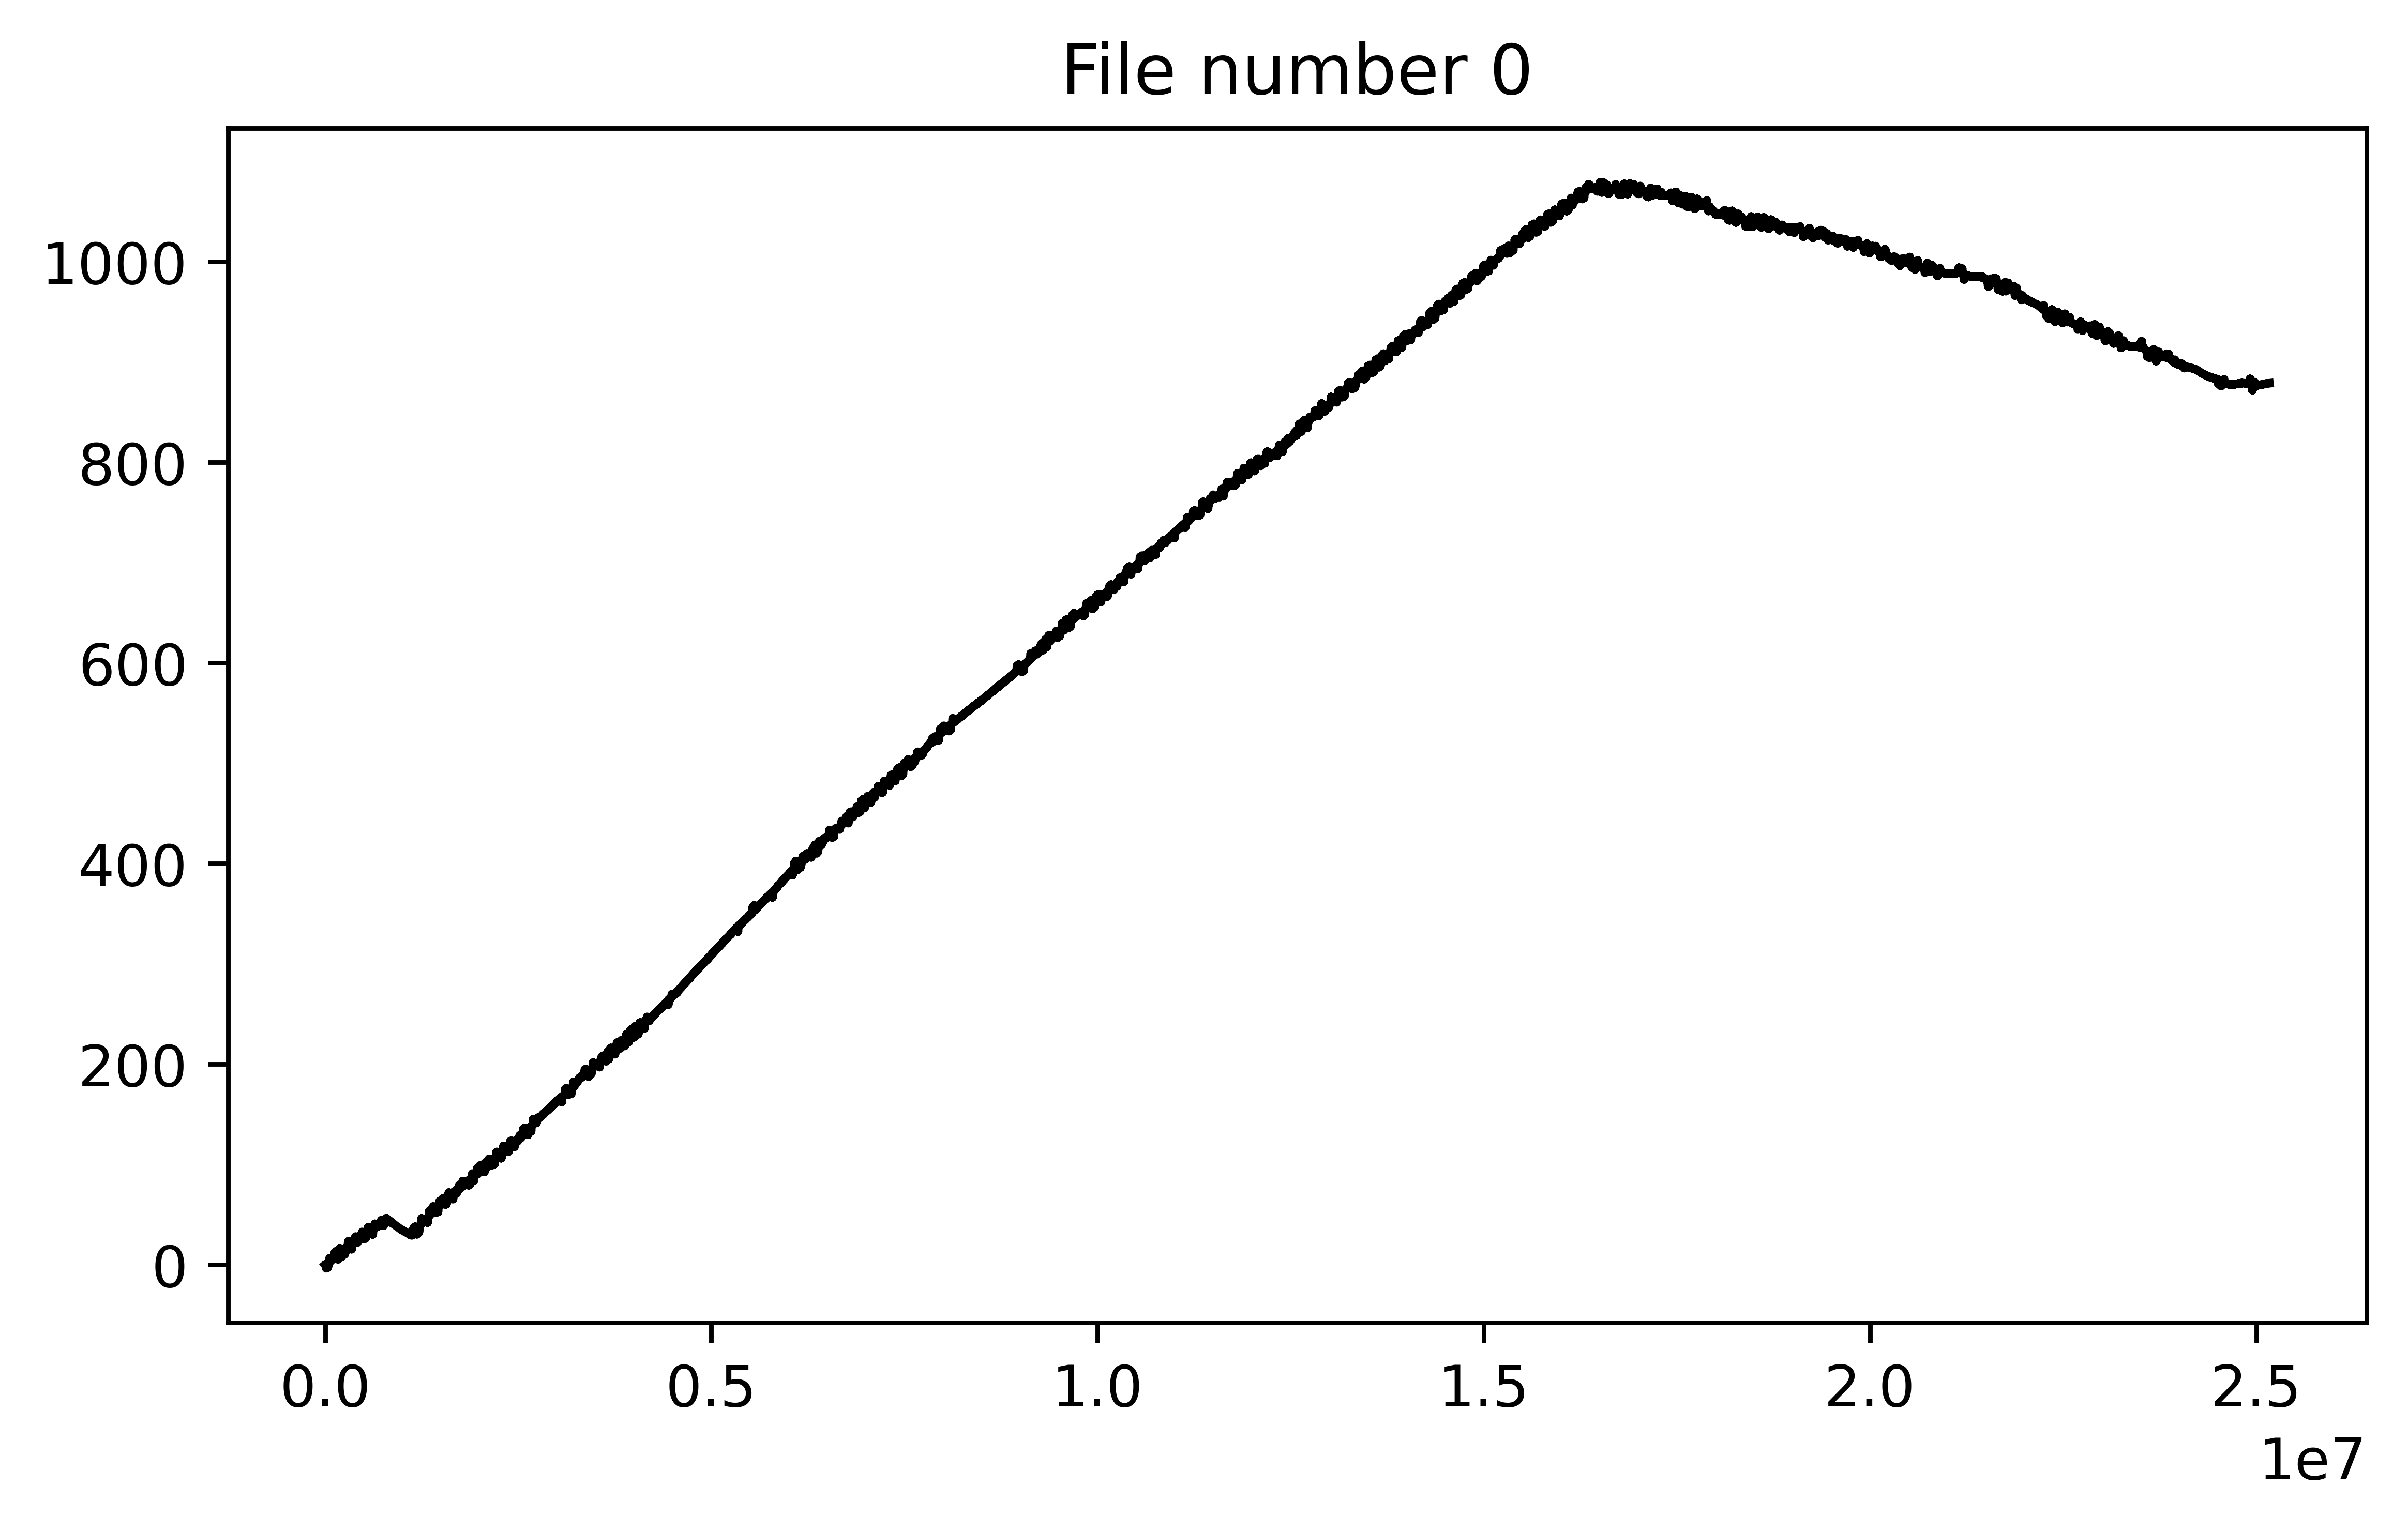

In [10]:
i = 0
for file in files:
    try:
        ODataSet = np.genfromtxt(open(folder+files[i],'r'), delimiter=',',skip_header=0,missing_values=0)
        Smooth = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        StdDevs = RollingStdDev(ODataSet[:,3],Smooth)
        StdDevs.append(0)
        StdDevs = np.asarray(StdDevs)
        SmoothDev = denoise_wavelet(StdDevs, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SquelchSignal = SquelchPattern(SmoothDev, 3000, 0.01)
        Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2])
        
        fig=plt.figure(figsize=(6.67,3.75),dpi=800,linewidth=0.25)
        plt.plot(Velocity)
        plt.title("File number " + str(i))
        plt.show()
    except:
        pass
    i+=1

In [11]:
def getVelocity0(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    if len(Timestamps) == len(Acceleration):
        pass
    else:
        print('error')

    #dTime = dTime / 10000.0

    for i in range(len(Acceleration)-1):
        j = i + 1
        dTime = Timestamps[j]-Timestamps[i]
        if dTime < 0: dTime -= 10000
        dTime /= 10000
        velocity[j] = velocity[i] + Acceleration[j] * dTime
    
    velocity *= 9.81

    return velocity


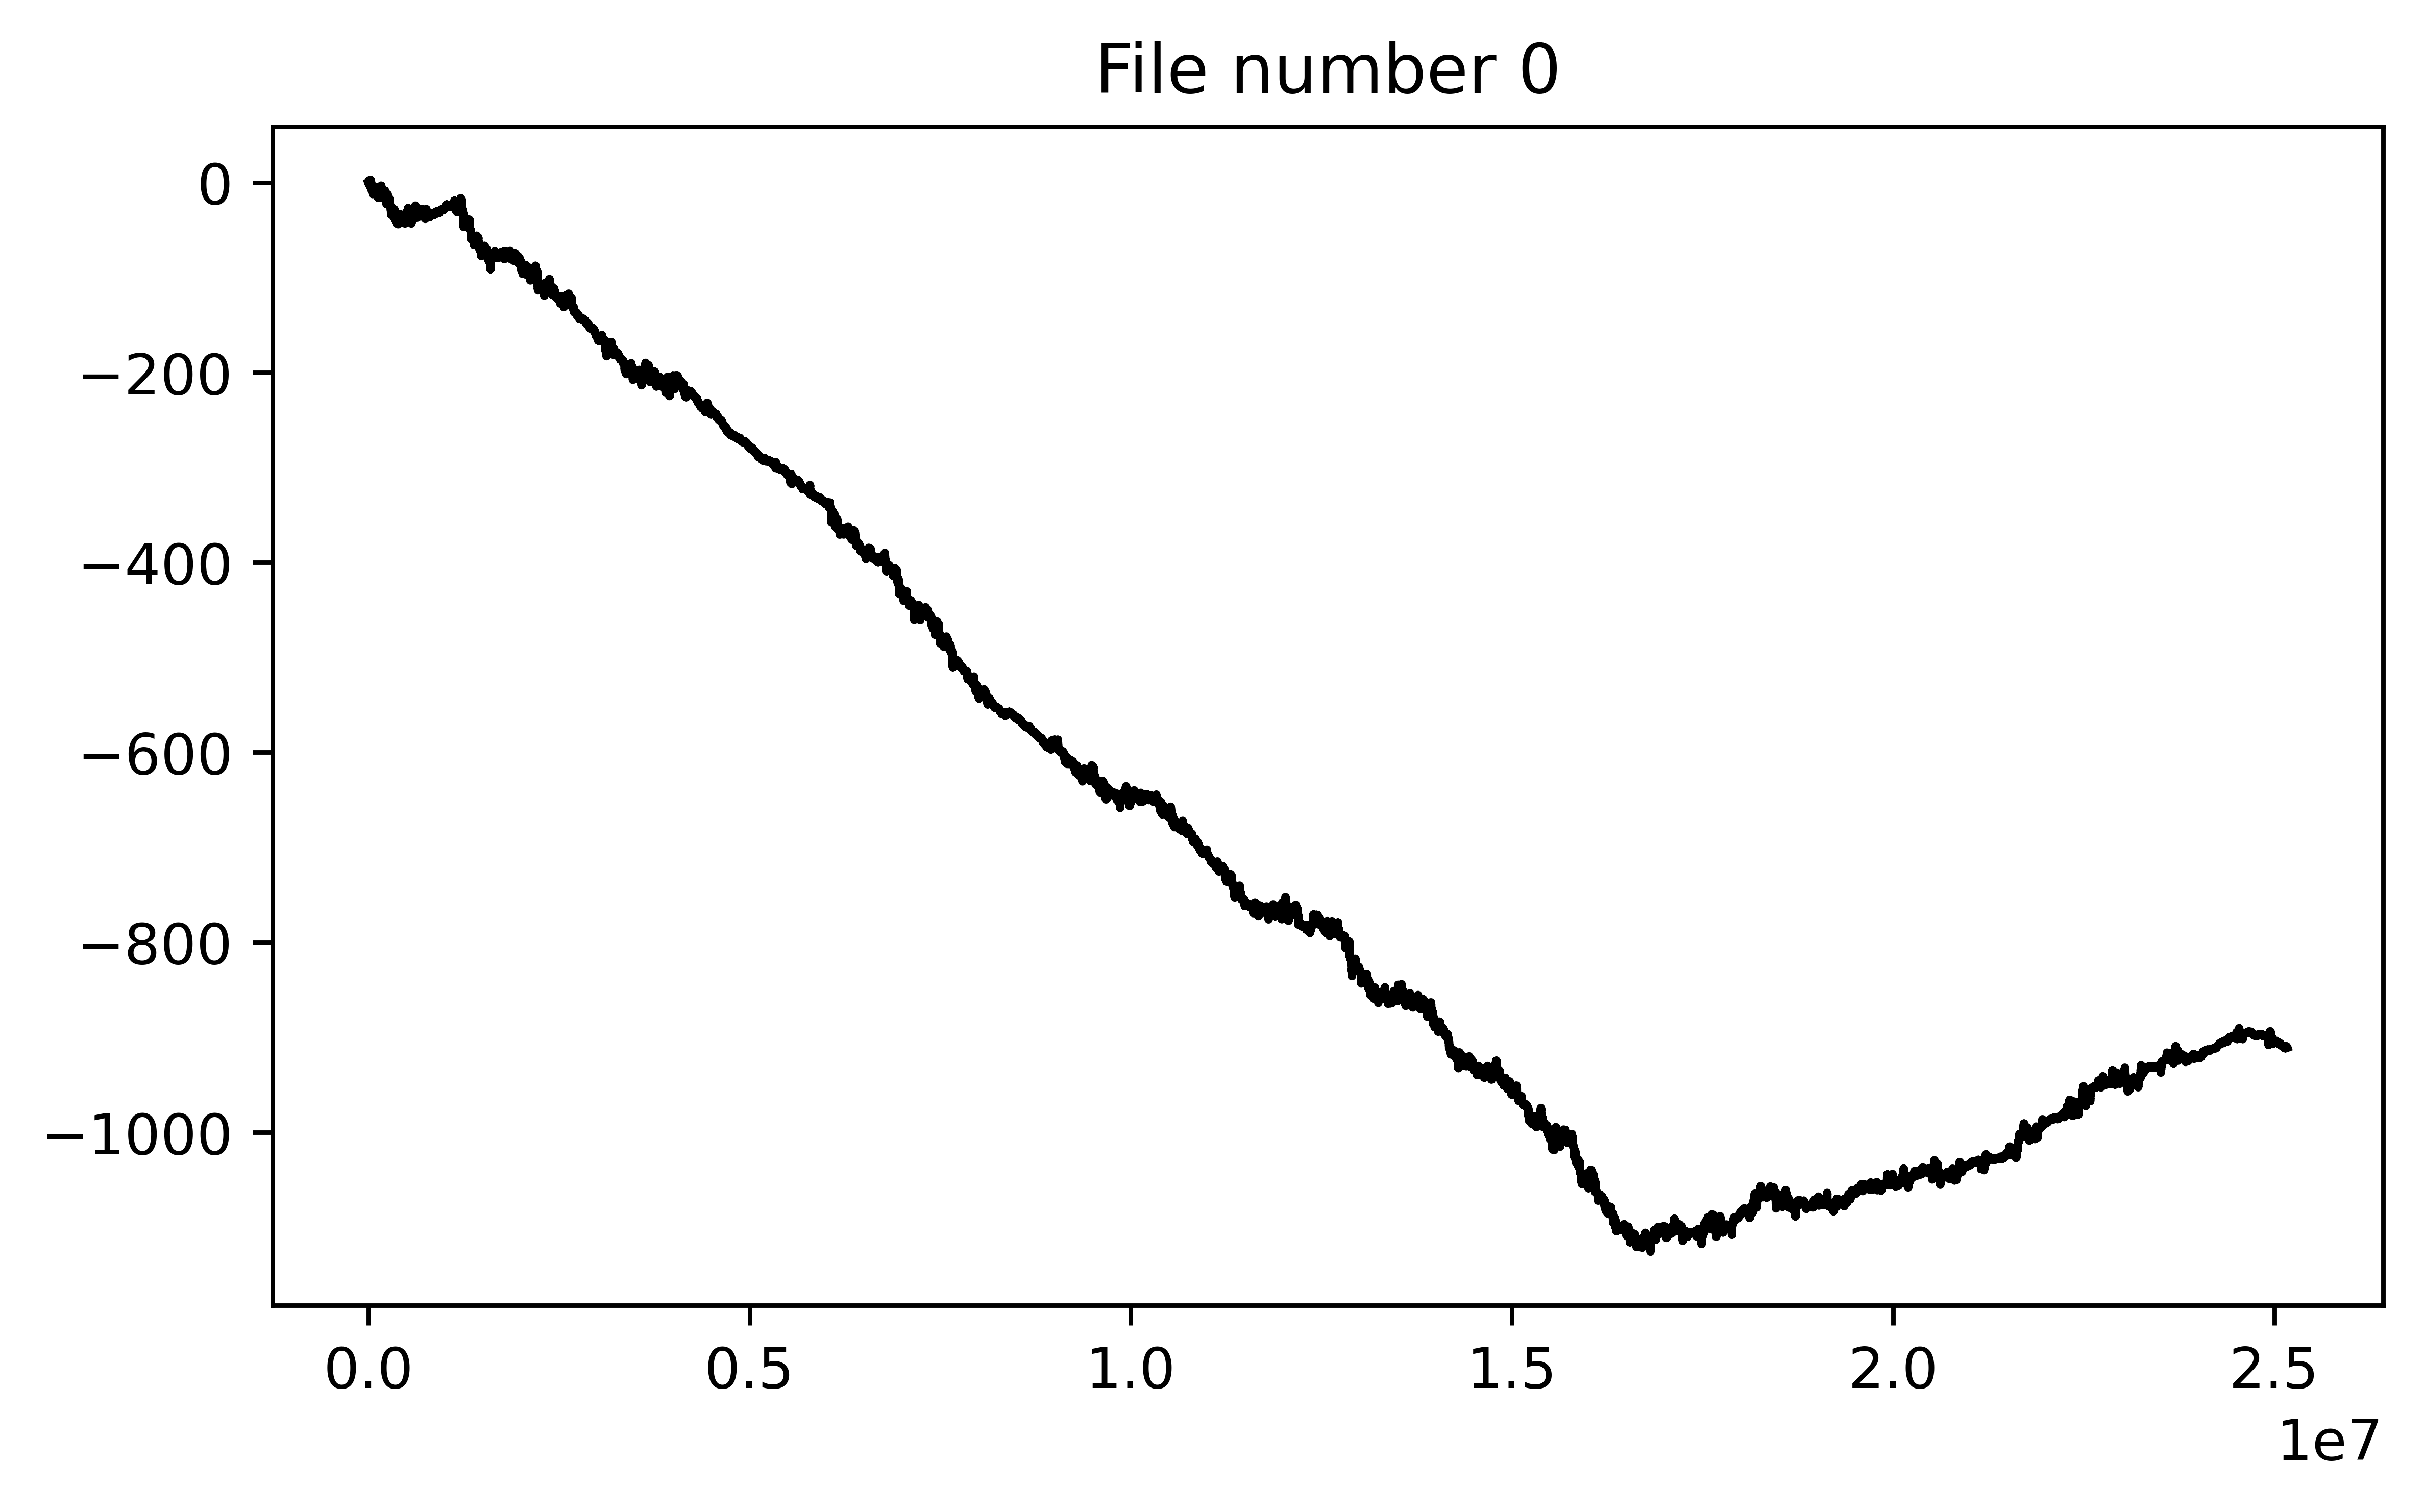

In [12]:
i = 0
for file in files:
    
    try:
        ODataSet = np.genfromtxt(open(folder+files[i],'r'), delimiter=',',skip_header=0,missing_values=0)

        Velocity = getVelocity0(ODataSet[:,3], ODataSet[:,2])
        
        fig=plt.figure(figsize=(6.67,3.75),dpi=800,linewidth=0.25)
        plt.plot(Velocity)
        plt.title("File number " + str(i))
        plt.show()
    except:
        pass

    i+=1

In [13]:
def getVelocity1(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    if len(Timestamps) == len(Acceleration):
        pass
    else:
        print('error')

    #dTime = dTime / 10000.0

    for i in range(len(Acceleration)-1):
        j = i + 1
        dTime = Timestamps[j]-Timestamps[i]
        if dTime < 0: dTime -= 10000
        dTime /= 10000
        velocity[j] = velocity[i] + Acceleration[j] * dTime
    
    velocity *= 9.81
    
    PointVairance = velocity[-1:] / len(velocity)
    for i in range(len(velocity)):
        velocity[i] -=  PointVairance * i
    return velocity        

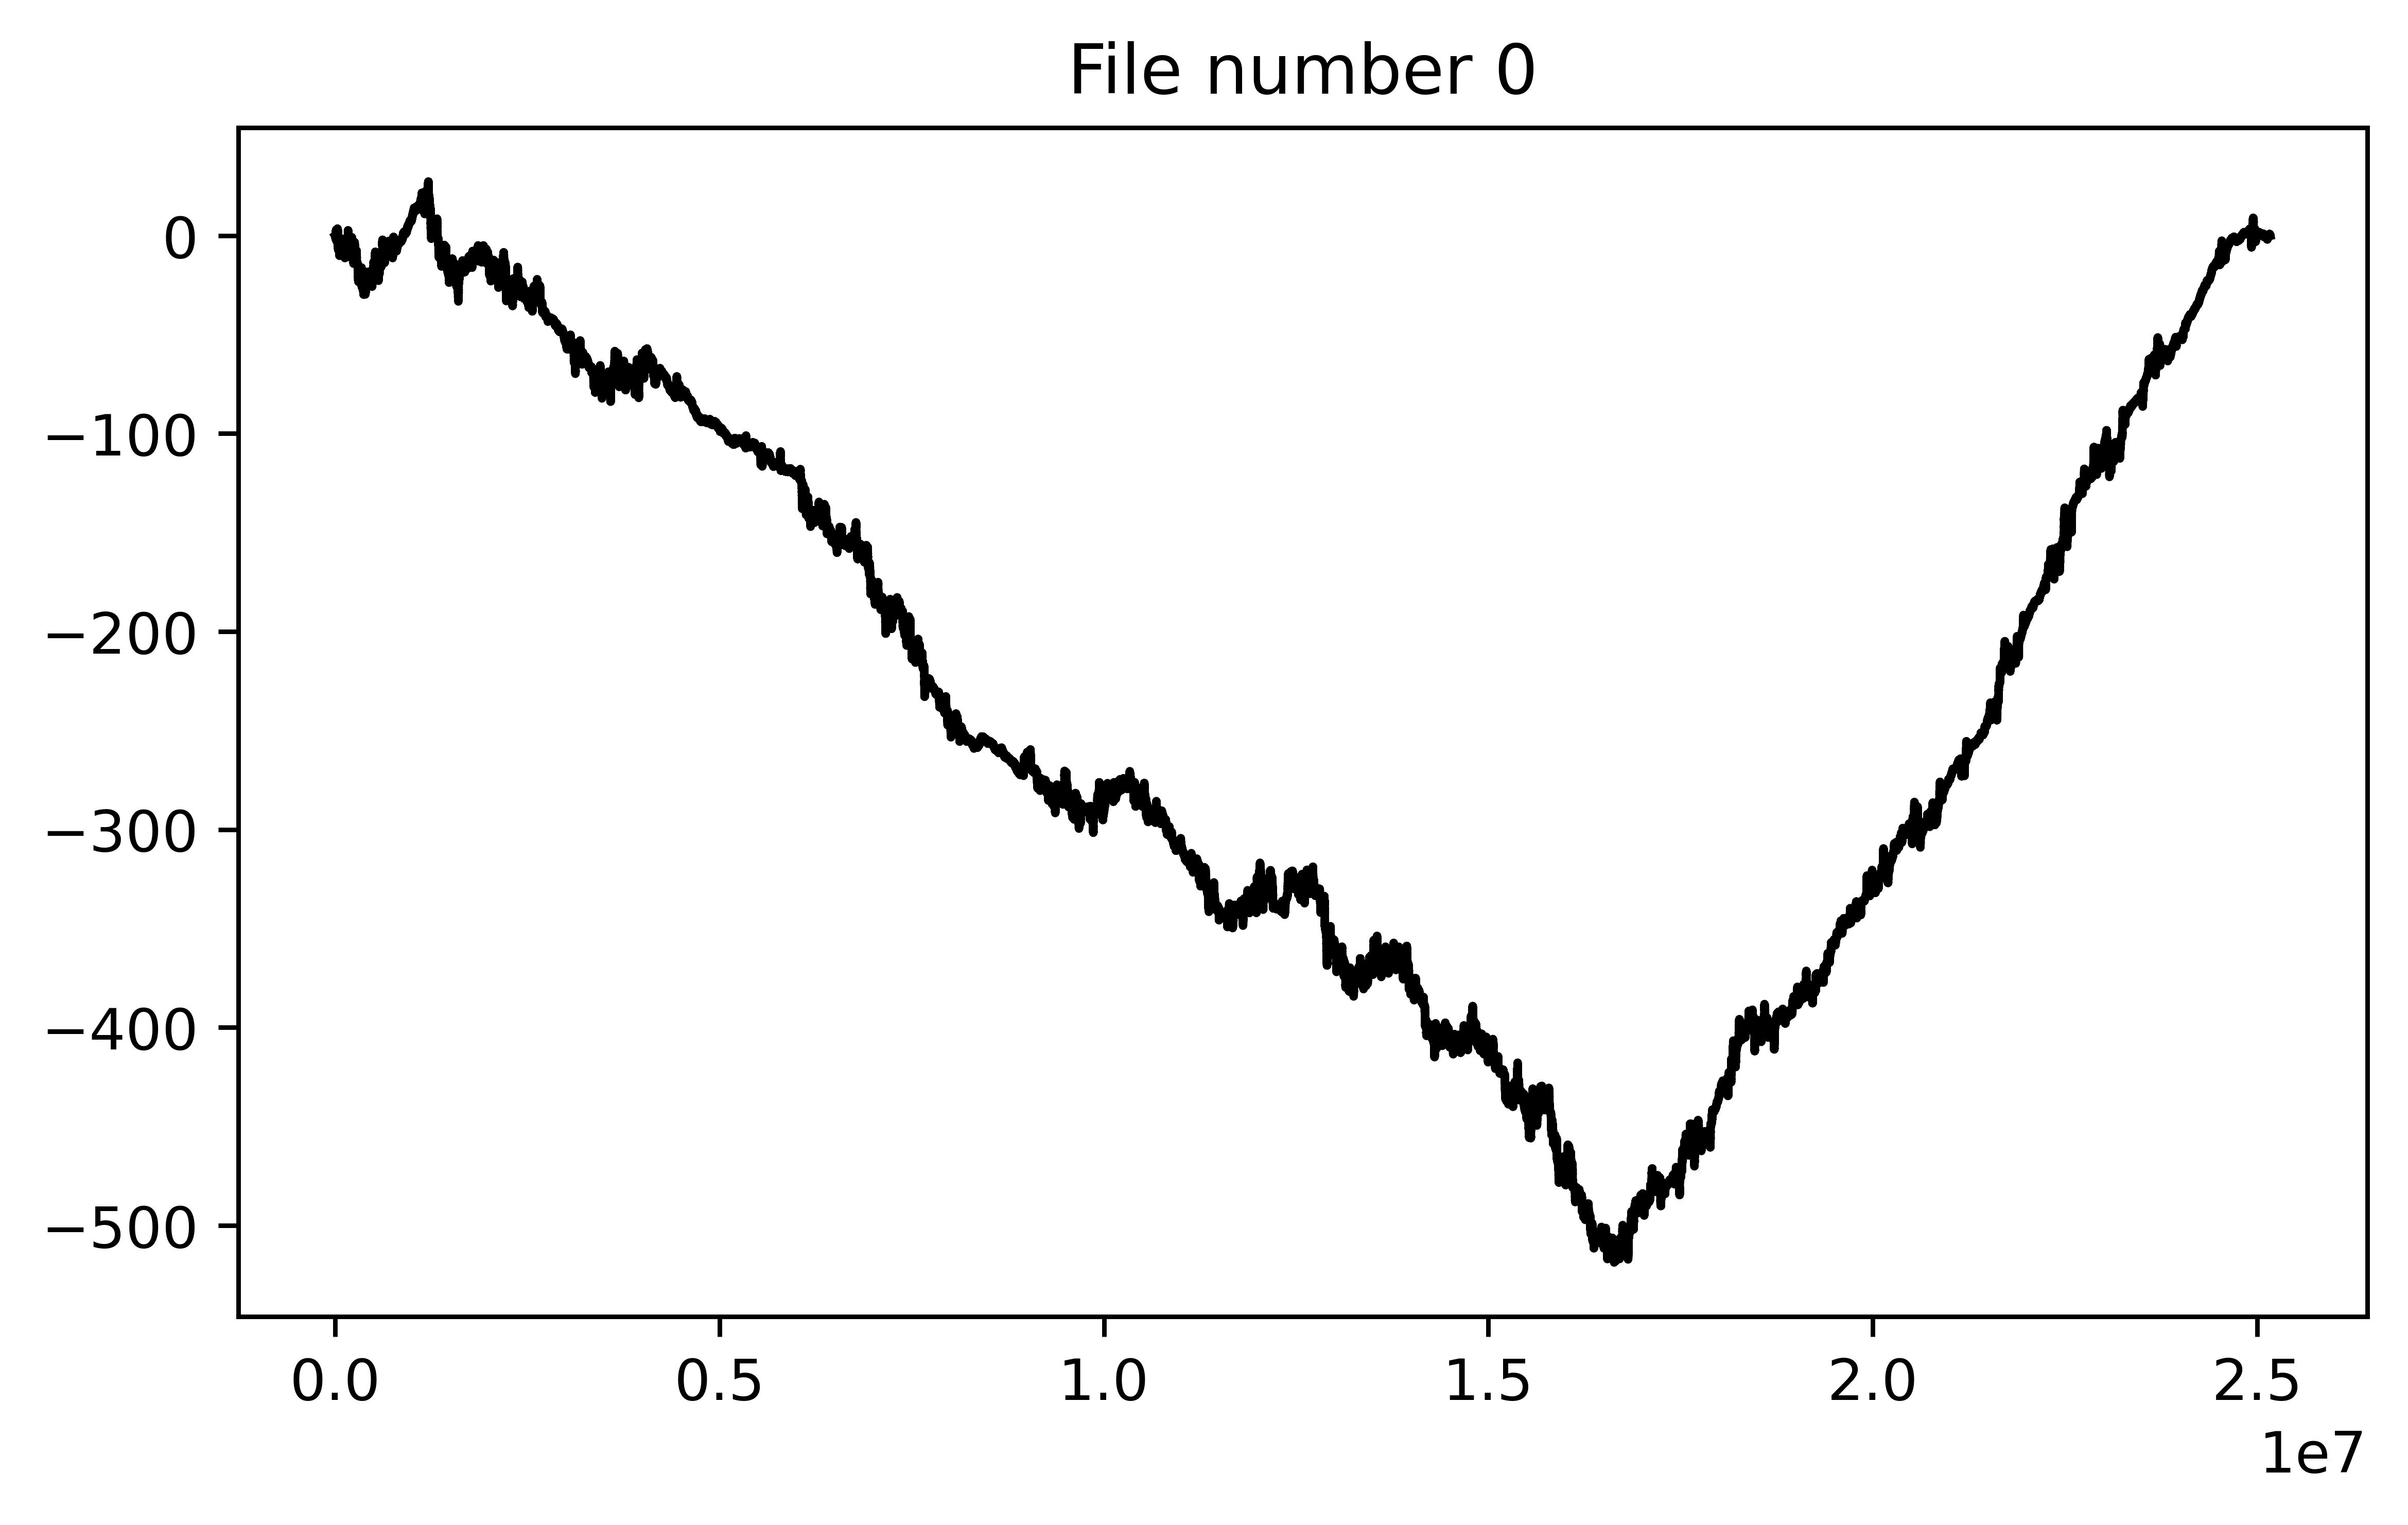

In [14]:
i=0
for file in files:
    try:
        ODataSet = np.genfromtxt(open(folder+files[i],'r'), delimiter=',',skip_header=0,missing_values=0)

        Velocity = getVelocity1(ODataSet[:,3], ODataSet[:,2])
        
        fig=plt.figure(figsize=(6.67,3.75),dpi=800,linewidth=0.25)
        plt.plot(Velocity)
        plt.title("File number " + str(i))
        plt.show()
    except:
        pass
    i+=1

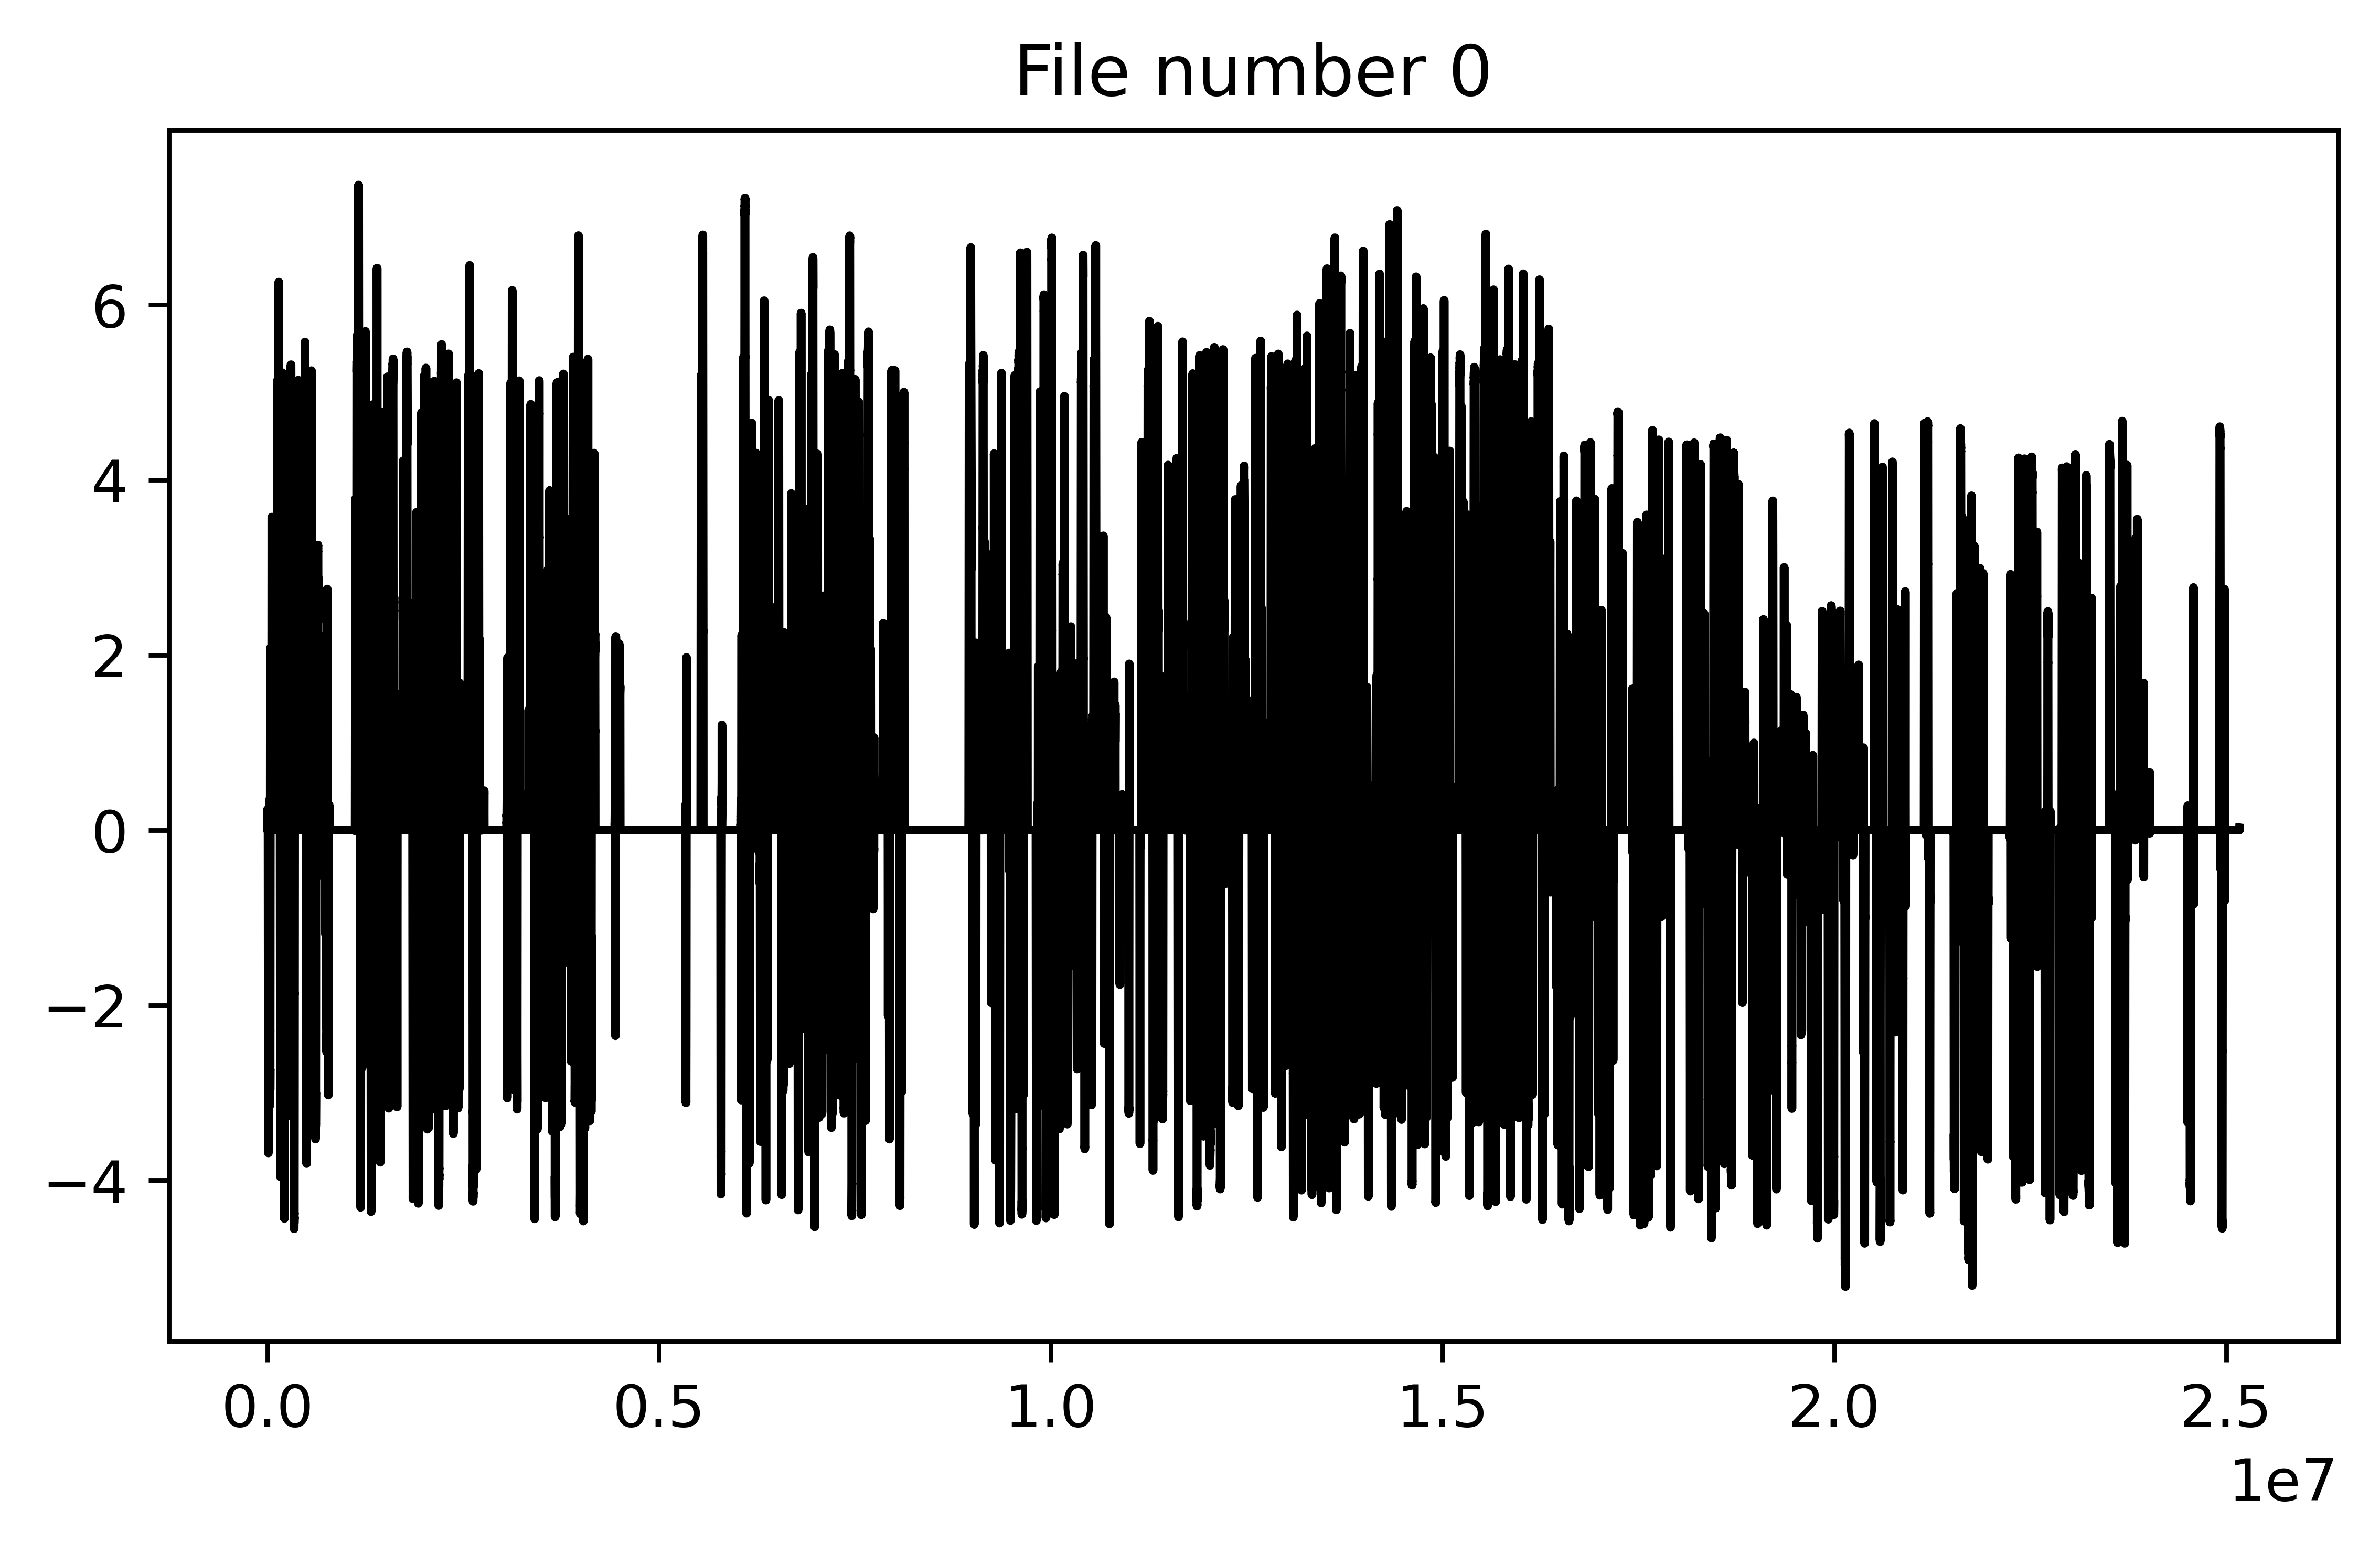

In [15]:
i=0
for file in files:
    try:
        ODataSet = np.genfromtxt(open(folder+files[i],'r'), delimiter=',',skip_header=0,missing_values=0)
        Smooth = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        StdDevs = RollingStdDev(ODataSet[:,3],Smooth)
        StdDevs.append(0)
        StdDevs = np.asarray(StdDevs)
        SmoothDev = denoise_wavelet(StdDevs, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SquelchSignal = SquelchPattern(SmoothDev, 3000, 0.01)
        Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        
        fig=plt.figure(figsize=(6.67,3.75),dpi=800,linewidth=0.25)
        plt.plot(Velocity)
        plt.title("File number " + str(i))
        plt.show()
    except:
        pass
    i+=1

In [16]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        try:
            ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0)
            Smooth = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
            #Smooth = cf.Smoothing(ODataSet[:,3],3)
            StdDevs = RollingStdDev(ODataSet[:,3],Smooth)
            #SmoothDev = cf.Smoothing(StdDevs,3)
            StdDevs.append(0)
            StdDevs = np.asarray(StdDevs)
            SmoothDev = denoise_wavelet(StdDevs, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
            SquelchSignal = SquelchPattern(SmoothDev, 3000, 0.01)
            Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
            RollSumStdDev = RollingSum(SmoothDev)
            #RollSumStdDev.append(0)
            RollSumStdDev = np.asarray(RollSumStdDev)
            Velocity = np.asarray(Velocity)
        except:
            Velocity = file
            StdDevs = 0
            RollSumStdDev = 0
            Smooth = 0
        return [Velocity, StdDevs, RollSumStdDev, Smooth]
    else:
        pass

In [17]:
i=0

start = 2250000
end = 2450000
        
ODataSet = np.genfromtxt(open(folder+files[i],'r'), delimiter=',',skip_header=0,missing_values=0)

Velocity = getVelocity1(ODataSet[start:end+1,3], ODataSet[start:end+1,2])


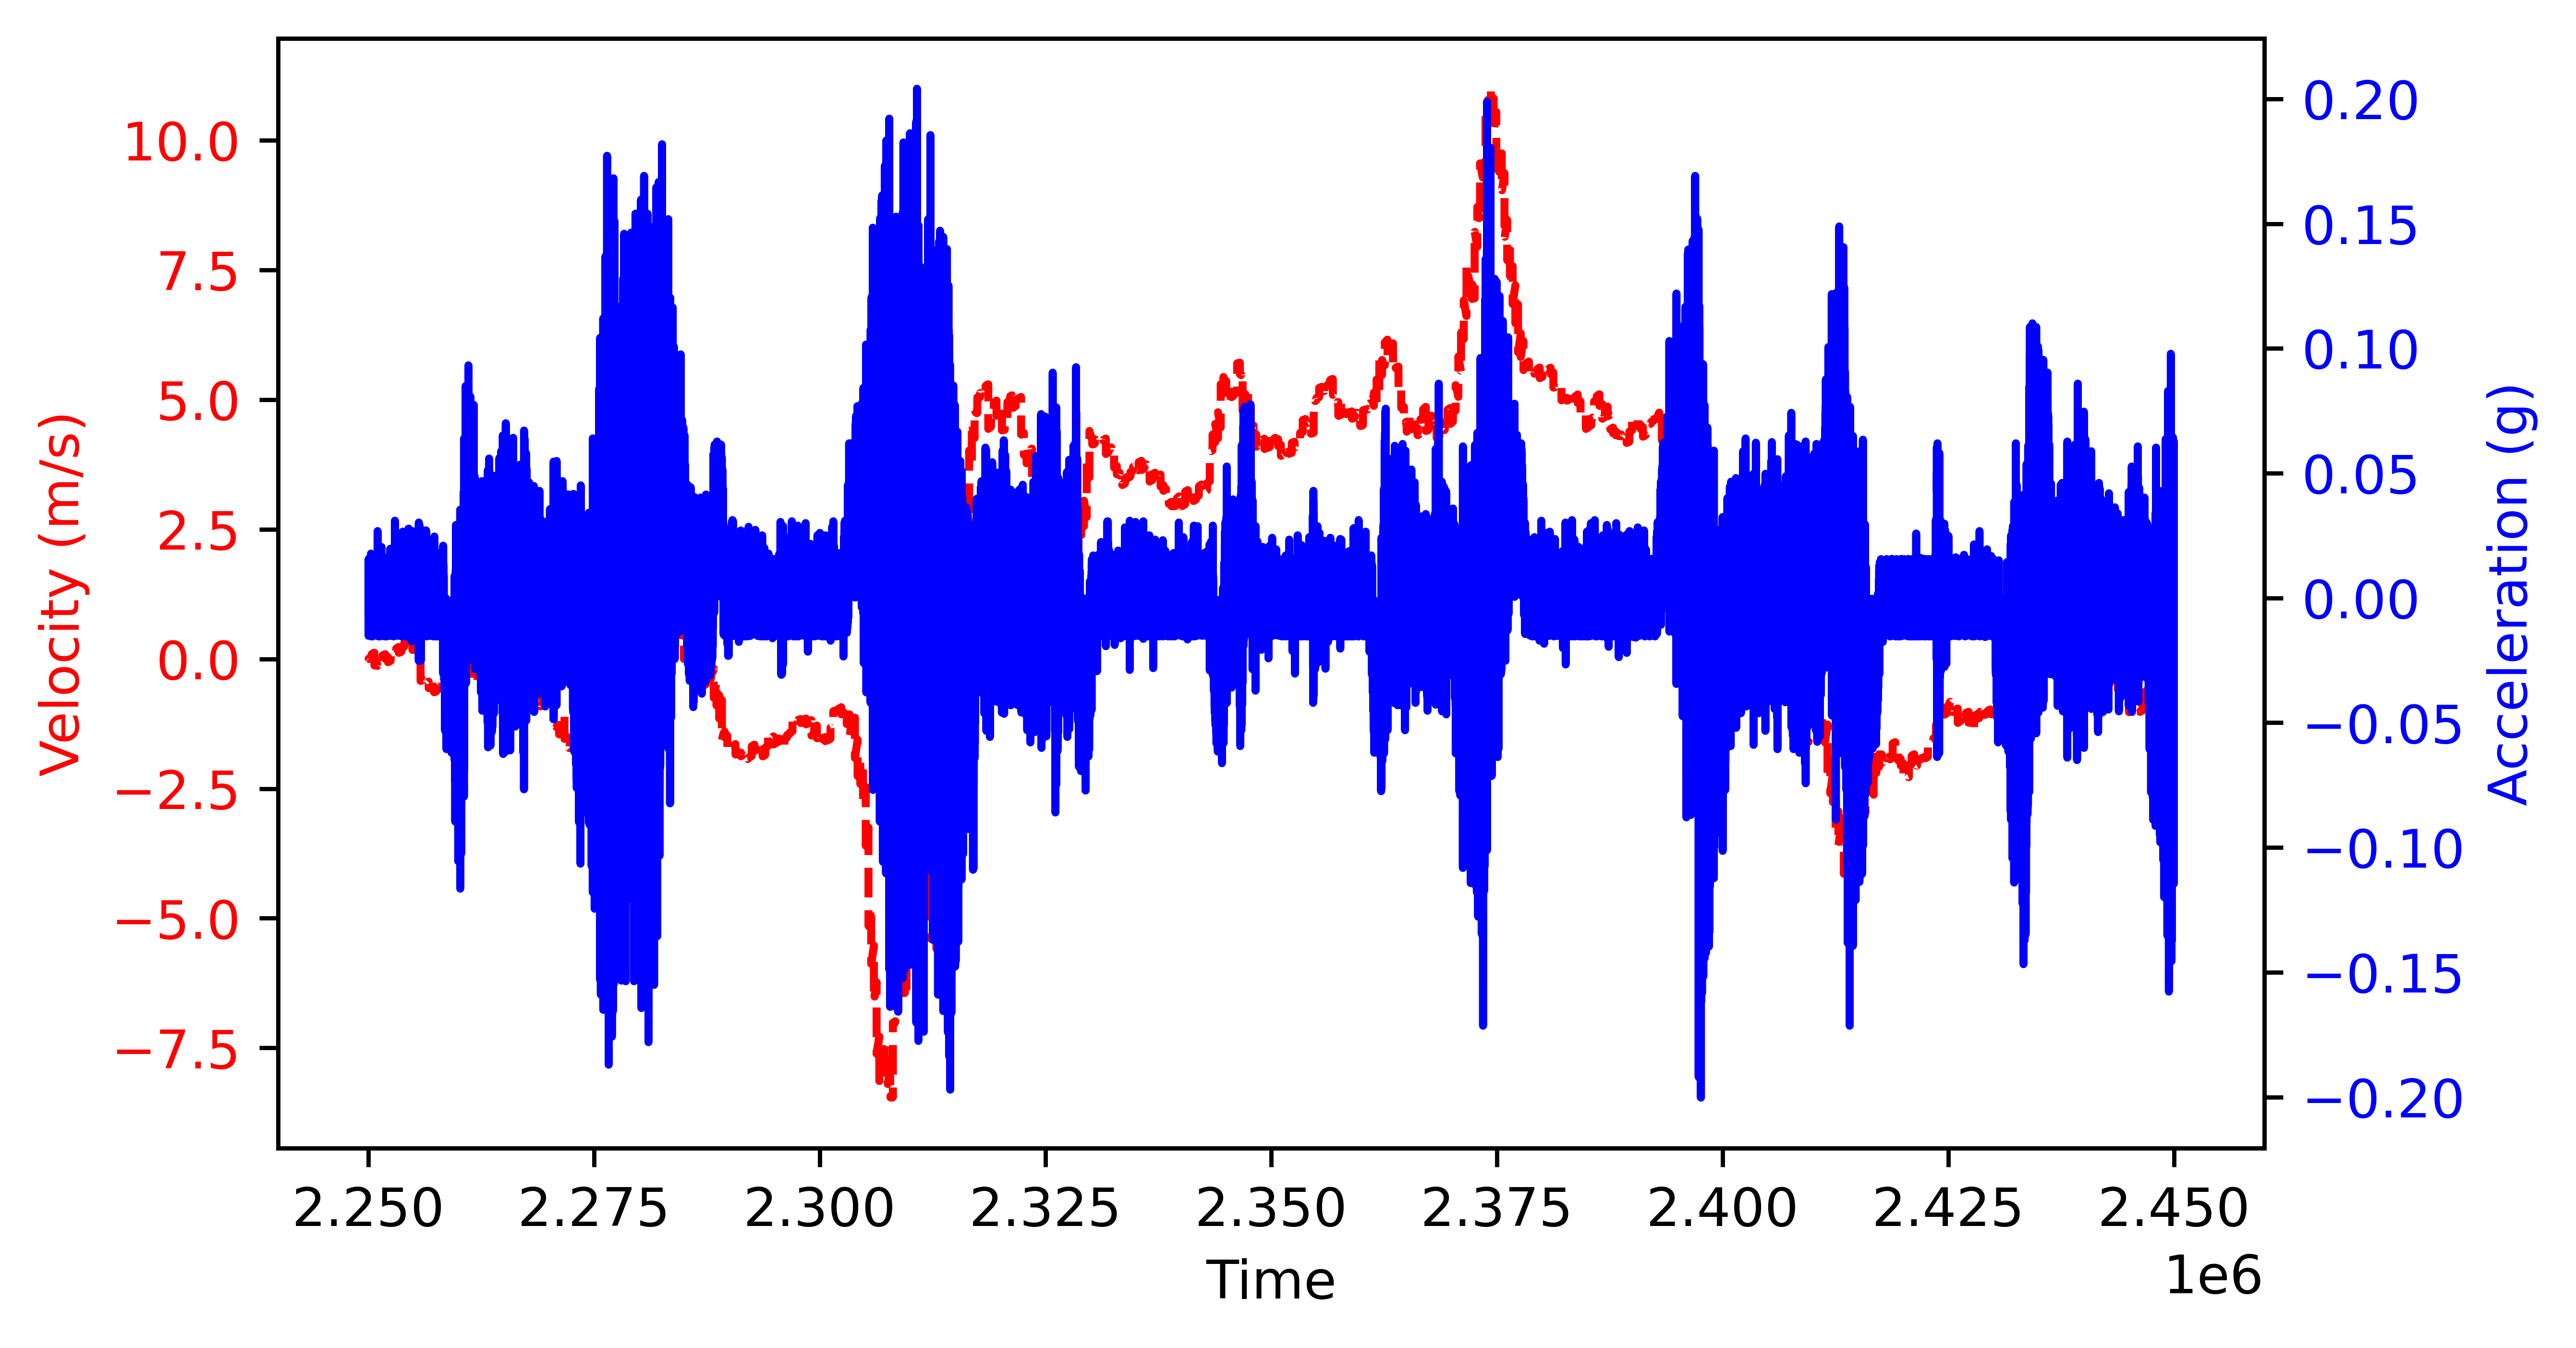

In [18]:
fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

PlotLength = end-start+1
v = Velocity
sd = ODataSet[start:end+1,3]

ax1.set_xlabel('Time') 
ax1.set_ylabel('Velocity (m/s)', color = 'red') 
ax1.plot(np.linspace(start,end,PlotLength), v, color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
#legend_1 = ax1.legend(loc=2)
#legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Acceleration (g)', color = 'blue') 
ax2.plot(np.linspace(start,end,PlotLength), sd, color = 'blue', label='Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
#ax2.legend(loc=1)
#ax2.add_artist(legend_1)
# Show plot

plt.show()

In [19]:
asdfadfadfadf

NameError: name 'asdfadfadfadf' is not defined

In [ ]:
Results = Parallel(n_jobs=16)(delayed(DeviationVelocity)(file) for file in files)
#Velocities, StdDevs, SumStdDevs, *fails = Parallel(n_jobs=17)(delayed(DeviationVelocity)(file) for file in files)

In [ ]:
Velocities = []
StdDevs = []
SumStdDevs = []
NewFiles=[]
Accels = []

for i in range(len(Results)):
    if Results[i] != None:
        Velocities.append(Results[i][0])
        StdDevs.append(Results[i][1])
        SumStdDevs.append(Results[i][2])
        NewFiles.append(files[i])
        Accels.append(Results[i][3])

In [ ]:
for i in range(len(Results)):
    print(np.shape(SumStdDevs[i]))

In [ ]:
start = 10000000
length = 200000
end = start+length

In [ ]:
fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

ax1.set_xlabel('Time') 
ax1.set_ylabel('m/s', color = 'red') 
#ax1.plot(range(length), Velocity[start:end], color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.plot(range(length), Velocities[f][start:end], color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
legend_1 = ax1.legend(loc=2)
legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Acceleration', color = 'blue') 
ax2.plot(range(length), StdDevs[f][start:end], color = 'blue', label='g of Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
ax2.legend(loc=1)
ax2.add_artist(legend_1)
# Show plot

plt.show()

In [ ]:
MaxDev=[]
MaxRoll=[]
for i in range(len(StdDevs)):
    MaxDev.append(np.max(StdDevs[i]))
    MaxRoll.append(np.max(SumStdDevs[i]))

In [ ]:
for i in range(len(MaxDev)):
    print(NewFiles[i],MaxDev[i], MaxRoll[i])